<a href="https://colab.research.google.com/github/JoaoDiamantino/calibrationModel/blob/main/calibrationProField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando Bibliotecas

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score



Carregando os Dados

In [116]:
urlSensor = 'https://raw.githubusercontent.com/JoaoDiamantino/calibrationModel/main/Sensor_FieldPRO.csv'
urlEstacao ='https://raw.githubusercontent.com/JoaoDiamantino/calibrationModel/main/Estacao_Convencional.csv'


dfSensor = pd.read_csv(urlSensor)
dfEstacao = pd.read_csv(urlEstacao)

Vamos fazer o *merge* das duas tabelas por meio das datas. Para isso as dados da
estação devem sofrer algumas alterações.

In [117]:
# Convertendo a coluna 'data' para o tipo de data e hora
dfEstacao['data'] = pd.to_datetime(dfEstacao['data'] + ' ' + dfEstacao['Hora (Brasília)'])

# Formatando a coluna 'data' para o mesmo formato que a coluna 'Datetime – utc'
dfEstacao['data'] = dfEstacao['data'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Excluindo coluna Hora (Brasília)
dfEstacao =dfEstacao.drop('Hora (Brasília)', axis=1)

# Exibindo o DataFrame dfEstacao após a transformação
dfEstacao.head(2)

,data,chuva
0,2020-09-01T00:00:00Z,0.0
1,2020-09-01T01:00:00Z,0.0


A linha 18 do dados do Sensor apresenta valor não arredondado das horas. Vamos ajustar e fazer a união dessas tabelas.

In [118]:
# Transformar o valor da linha 18 da coluna em hora exata
new_value = '2020-10-01T19:00:00Z'
dfSensor.at[18, 'Datetime – utc'] = new_value

# Mesclar os DataFrames com base na coluna 'data'
dfMerged = pd.merge(dfSensor, dfEstacao, left_on='Datetime – utc', right_on='data', how='left').drop('data', axis=1)
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711 entries, 0 to 1710
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datetime – utc       1711 non-null   object 
 1   air_humidity_100     1705 non-null   float64
 2   air_temperature_100  1705 non-null   float64
 3   atm_pressure_main    1711 non-null   int64  
 4   num_of_resets        1711 non-null   int64  
 5   piezo_charge         1711 non-null   int64  
 6   piezo_temperature    1711 non-null   int64  
 7   chuva                1529 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 120.3+ KB


Com o dataframe unido, vamos tratar os valores nulos. Percebemos uma quantidade significativa de valores faltantes na coluna 'chuva'. Isso se deve ao fato de que a estação não fez a coleta de informções a partir de determinado período. Vamos salvar essas informações para que possamos usar para fazer predições posteriormente. Para as demais colunas, vamos fazer o preenchimento repetindo informações da hora anterior.

In [119]:
# Salvando períodos de chuva ainda não medidos pela Estação
dfTeste = dfMerged.loc[dfMerged['chuva'].isnull()]

# Eliminado valores nulos (ainda não medidos pelas estação)
dfMerged = dfMerged.dropna(subset=['chuva'])

# Preencher os valores nulos das colunas 'air_humidity_100' e 'air_temperature_100' com os valores da linha anterior
dfMerged['air_humidity_100'].fillna(method='ffill', inplace=True)
dfMerged['air_temperature_100'].fillna(method='ffill', inplace=True)


O impacto das gotas de chuva gera vibrações no piezoelétrico, que induzem uma
corrente elétrica. A corrente elétrica não é medida diretamente, mas é acumulada
ao longo do tempo e gera uma queda na carga do acumulador. Sendo assim, podemos gerar uma nova coluna para calcular o quanto houve de perda de carga.


In [120]:
# Calculando a diferença entre os valores consecutivos de piezo_charge
dfMerged['piezo_charge_diff'] = (dfMerged['piezo_charge'].diff().fillna(method='bfill')) * (-1)

# Transformando os valores de ganho de carga pelo Reset em valor igual ao anterior
dfMerged['piezo_charge_diff'] = dfMerged['piezo_charge_diff'].where(dfMerged['piezo_charge_diff'] >= 0, dfMerged['piezo_charge_diff'].shift())

Uma informação importante é classificarmos os dados em ocorrência de chuva ou não. Percebemos que são poucos os dados com ocorrência de chuva, mas essa identificação vai ser importante para criação de novas features.

In [121]:
# Criar a coluna "choveu" com base nos valores da coluna "chuva" para indicar se choveu ou não
dfMerged['choveu'] = (dfMerged['chuva'] > 0).astype(int)

In [122]:
dfMerged['choveu'].value_counts()

0    1474
1      55
Name: choveu, dtype: int64

EAD

In [123]:
dfMerged.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva,piezo_charge_diff,choveu
count,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000
mean,58.541530,24.818628,9432.371485,1.485284,44206.215173,25.068672,0.093133,86.990844,0.035971
std,21.901846,6.318904,27.338256,1.042274,12628.075560,8.522752,0.828208,48.873099,0.186279
min,13.000000,12.360000,9350.000000,0.000000,16950.000000,11.000000,0.000000,39.000000,0.000000
25%,39.000000,19.946000,9415.000000,1.000000,34709.000000,18.000000,0.000000,59.000000,0.000000
50%,59.000000,23.178000,9433.000000,1.000000,43968.000000,22.000000,0.000000,72.000000,0.000000
75%,78.000000,29.780000,9451.000000,2.000000,54993.000000,32.000000,0.000000,107.000000,0.000000
max,99.000000,42.664000,9507.000000,3.000000,65533.000000,47.000000,16.800000,857.000000,1.000000


Uma informação importante para nosso modelo é ocorrência de chuva. Com isso podemos identificar algumas condições no sensor em que geralmente as chuvas ocorrem.

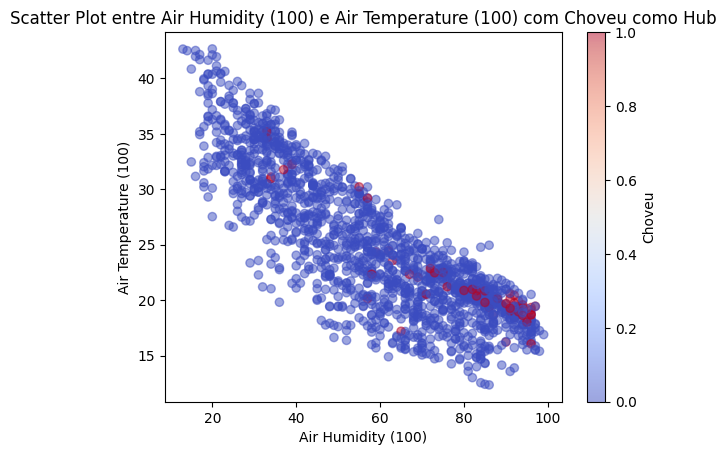

In [124]:
# Criar o gráfico de dispersão (scatter plot) com a coluna "choveu" como hub (central)
plt.scatter(dfMerged['air_humidity_100'], dfMerged['air_temperature_100'], c=dfMerged['choveu'], cmap='coolwarm', alpha=0.5)

# Configurar os rótulos do eixo x e y
plt.xlabel('Air Humidity (100)')
plt.ylabel('Air Temperature (100)')

# Configurar o título do gráfico
plt.title('Scatter Plot entre Air Humidity (100) e Air Temperature (100) com Choveu como Hub')

# Adicionar uma legenda para a coluna "choveu"
plt.colorbar(label='Choveu')

# Exibir o gráfico
plt.show()

Percebemos pelo gráfico que a incidência de chuva se dá em períodos com mais de 60 de humidade do ar e abaixo de 25 graus de temperatura. Com isso podemos criar uma nova coluna chamada 'condicoes_chuva' que indique com o valor 1 se essas condições são atendidas

In [125]:
# Criar uma nova coluna "condicoes_chuva" que será 1 se a umidade for maior que 55 e a temperatura for menor que 25 e 0 caso contrário
dfMerged['condicoes_chuva'] = ((dfMerged['air_humidity_100'] > 55) & (dfMerged['air_temperature_100'] < 25)).astype(int)
dfMerged['condicoes_chuva'].value_counts()

1    776
0    753
Name: condicoes_chuva, dtype: int64

Fazendo uma análise similar com piezo_temperature e a perda de carga, não encontramos nenhum padrão para incidência de chuva. A temperatura do piezo é muito relacionada com a temperatura externa. Não criaremos nenhuma nova variável aqui.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


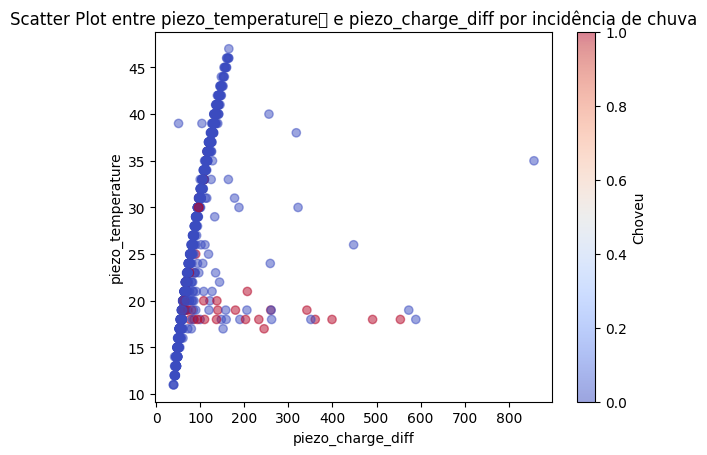

In [126]:
# Criar o gráfico de dispersão (scatter plot) com a coluna "choveu" como hub (central)
plt.scatter(dfMerged['piezo_charge_diff'], dfMerged['piezo_temperature'], c=dfMerged['choveu'], cmap='coolwarm', alpha=0.5)

# Configurar os rótulos do eixo x e y
plt.xlabel('piezo_charge_diff')
plt.ylabel('piezo_temperature')

# Configurar o título do gráfico
plt.title('Scatter Plot entre piezo_temperature	 e piezo_charge_diff por incidência de chuva')

# Adicionar uma legenda para a coluna "choveu"
plt.colorbar(label='Choveu')

# Exibir o gráfico
plt.show()

É esperado que um maior volume de chuva cause maior perda de carga no acumulador. O Gráfico abaixo vai nos dá essa relação entre a quantidade de chuva e a quantidade de perda de carga.

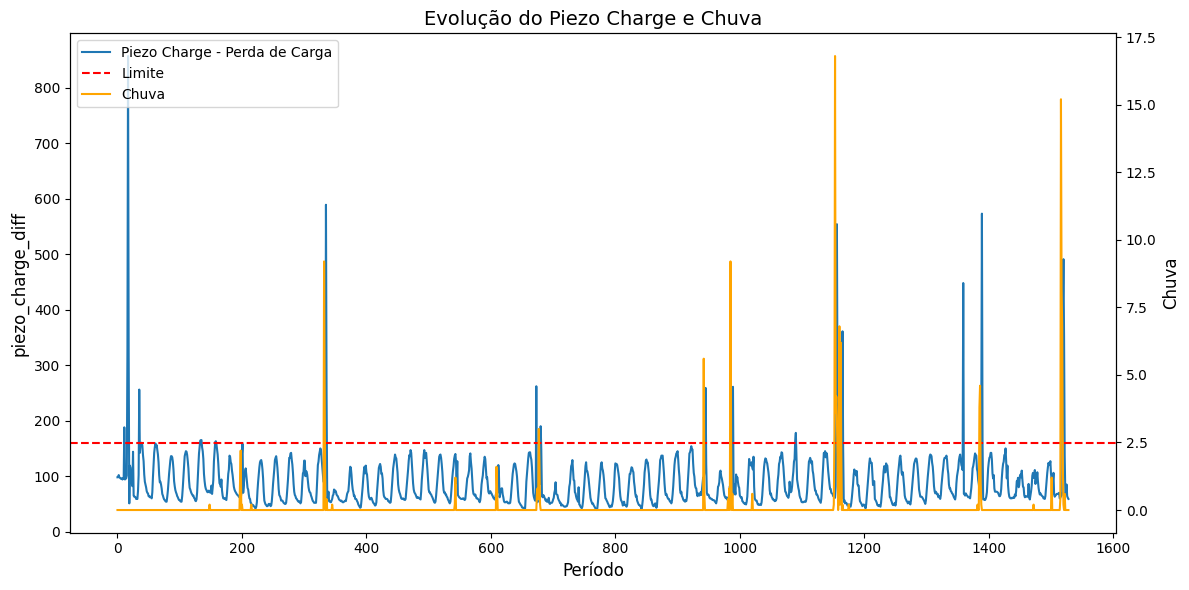

In [127]:
# Configurando o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando o gráfico de linha para o piezo charge
ax1 = plt.gca()
ax1.plot(dfMerged.index, dfMerged['piezo_charge_diff'], label='Piezo Charge - Perda de Carga')
ax1.set_xlabel('Período', fontsize=12)
ax1.set_ylabel('piezo_charge_diff', fontsize=12)
ax1.set_title('Evolução do Piezo Charge e Chuva', fontsize=14)

# Criando o segundo eixo para as barras de chuva com escala própria
ax2 = ax1.twinx()
ax2.plot(dfMerged.index, dfMerged['chuva'], alpha=1, color='orange', label='Chuva')
ax2.set_ylabel('Chuva', fontsize=12)


# Adicionando a linha vertical vermelha de referencia
ax1.axhline(160, color='red', linestyle='--', label='Limite')

# Mostrando a legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Mostrando o gráfico
plt.tight_layout()
plt.show()



Notamos no gráfico que valores de perda de carga de mais de 160 podem, na maioria dos casos, ser resultado da presença de chuvas maiores. Podemos criar uma coluna 'perda_por_chuva" que nos traga essa informação para o modelo.

In [128]:
# Criar uma nova coluna "condicoes_chuva" que será 1 se a umidade for maior que 60 e a temperatura for menor que 25 e 0 caso contrário
dfMerged['perda_por_chuva'] = ((dfMerged['piezo_charge_diff'] > 160)).astype(int)
dfMerged['perda_por_chuva'].value_counts()

0    1497
1      32
Name: perda_por_chuva, dtype: int64

O Gráfico abaixo nos mostra a relação da temperaturado piezo com a perda de cargo. Essa relação pode nos mostra que há uma perda natural de carga de acordo com a variação da temperatura de maneira proporcional. Casos extremos de perda são provenietes de outros efeitos, como a chuva.

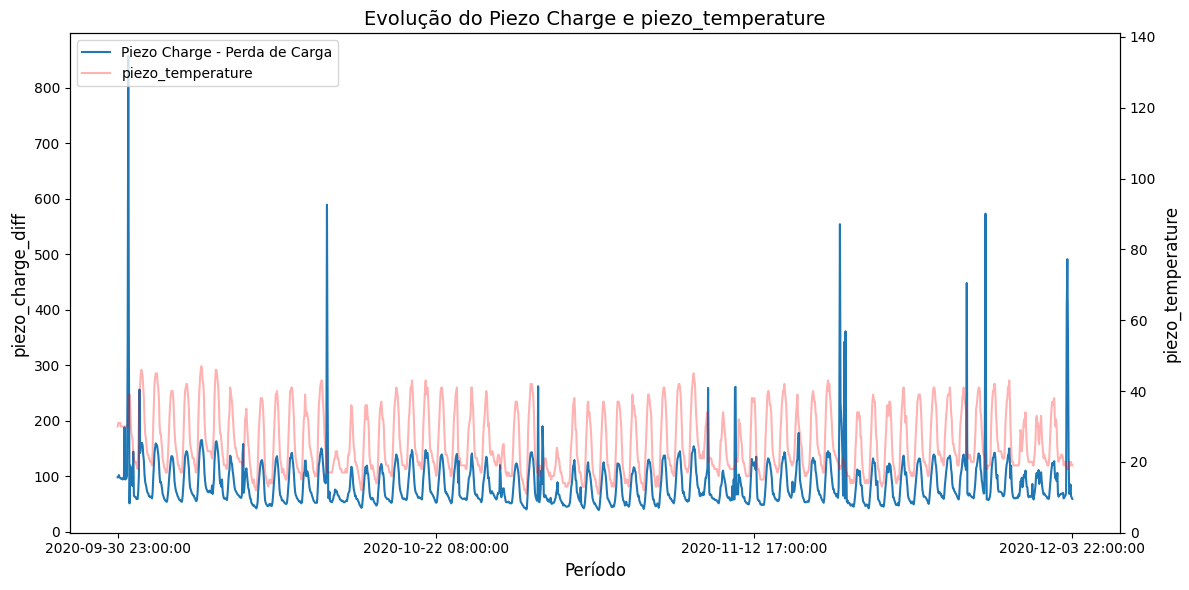

In [129]:
# Convertendo a coluna 'Datetime – utc' para o formato datetime
dfMerged['Datetime – utc'] = pd.to_datetime(dfMerged['Datetime – utc'])


# Configurando o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando o gráfico de linha para o piezo charge
ax1 = plt.gca()
ax1.plot(dfMerged.index, dfMerged['piezo_charge_diff'], label='Piezo Charge - Perda de Carga')
ax1.set_xlabel('Período', fontsize=12)
ax1.set_ylabel('piezo_charge_diff', fontsize=12)
ax1.set_title('Evolução do Piezo Charge e piezo_temperature', fontsize=14)

# Criando o segundo eixo para as barras de chuva com escala própria
ax2 = ax1.twinx()
ax2.plot(dfMerged.index, dfMerged['piezo_temperature'], alpha=0.3, color='red', label='piezo_temperature')
ax2.set_ylabel('piezo_temperature', fontsize=12)

# Ajustando a escala do eixo chuva para o dobro dos valores atuais
ax2.set_ylim(0, dfMerged['piezo_temperature'].max() * 3.0)


# Manipulando os rótulos do eixo x para mostrar apenas algumas datas
n = 3
plt.xticks(dfMerged.index[::len(dfMerged.index)//n], dfMerged['Datetime – utc'][::len(dfMerged.index)//n].dt.strftime('%Y-%m-%d %H:%M:%S'))

# Mostrando a legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Mostrando o gráfico
plt.tight_layout()
plt.show()


Vimos em que os períodos que não choveram são muito maiores dos que com chuva, o que pode criar um viés nos resultados. Vamos fazer um balanceamento dos dados, trabalhando com uma proporção de 80/20 de não chuva e chuva

In [130]:
# Separar os dataframes em que choveu e não choveu

dfChuva = dfMerged[dfMerged['chuva'] > 0]
dfNaoChuva = dfMerged[dfMerged['chuva'] == 0.0]

# Contar a quantidade de exemplos em cada classe
minority_count = dfChuva.shape[0]
majority_count = dfNaoChuva.shape[0]

# Contar quantos exemplos majoritários devem ser mantidos (60% do total de exemplos minoritários)
desired_majority_count = int(minority_count * 4)

# Selecionar aleatoriamente amostras da classe majoritária para manter a proporção 60/40
dfNaochuva_sampled = dfNaoChuva.sample(n=desired_majority_count, random_state=42)

# Juntar as amostras das classes minoritárias e majoritárias
dfBalanced = pd.concat([dfChuva, dfNaochuva_sampled], ignore_index=True)

# Embaralhar os dados para garantir ordem aleatória
dfBalanced = dfBalanced.sample(frac=1, random_state=42)

dfBalanced['choveu'].value_counts()

0    220
1     55
Name: choveu, dtype: int64

Definindo variáveis preditoras

<ipython-input-131-e6e2ffadd10f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dfBalanced.corr()


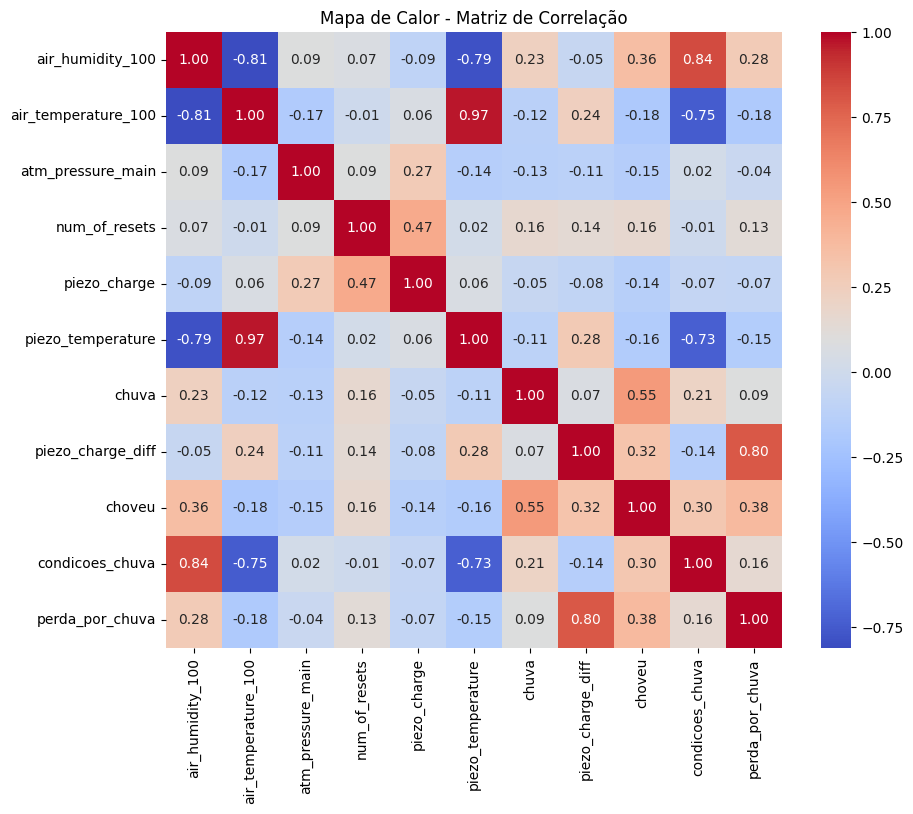

In [131]:
# Calculando a matriz de correlação
correlation_matrix = dfBalanced.corr()

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Plotando o mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Mostrando o gráfico
plt.title('Mapa de Calor - Matriz de Correlação')
plt.show()

Com base no estudo das correlações, temos que 'air_temperature'é uma feature candidata a ser excluída do modelo devido a alta correlação com 'piezo_temperature'.
Além disso, 'Piezo_Charge' tem uma correlação quase nula com nosso target, além do que,pelo contexto, não faz sentido mantê-la. O mesmo vale para o 'num_of_resets', que pelo contexto, não é uma feature que façasentido manter.

Nossa variável target será a coluna 'chuva'. O modelo escolhido deverá ser capaz de trazer o valor dessa variável o mais próximo do real, com base nas variáveis preditoras escolhidas

In [132]:
# Dividindo os dados em características (X) e rótulo (y)
X = dfBalanced.drop(['Datetime – utc','chuva','choveu','piezo_charge',"num_of_resets","piezo_temperature"], axis=1)
y = dfBalanced['chuva']


#Dividindo os dados em conjuntos de treinamento e teste (70% treinamento, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



O código abaixo é uma implementação de um modelo de **Random Forest Regressor** usando a biblioteca scikit-learn em Python. O objetivo é prever valores contínuos (regressão) para a variável target com base em um conjunto de features.

São calculadas algumas métricas de desempenho, como Mean Squared Error **(MSE)**, Mean Absolute Error **(MAE)**, Median Absolute Error e **(MedAE)** , para avaliar o quão bem o modelo está fazendo as previsões em relação aos valores reais do target (y_test). Essas métricas fornecem uma medida da precisão do modelo, e valores menores para MSE, MAE e MedAE

In [133]:
# Padronizar os dados de treino e teste
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criar o modelo de Random Forest para regressão
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo com os dados de treino padronizados
model.fit(X_train_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Calcular as métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: ',mean_squared_error(y_test, y_pred))
print('MAE: ',mean_absolute_error(y_test, y_pred))
print('MEDAE: ',median_absolute_error(y_test, y_pred))

MSE:  6.477848240963856
MAE:  0.9161204819277108
MEDAE:  0.10800000000000004


Vamos ver a performance do modelo utilizando também o **Gradient Boosting**.

Gradient Boosting é uma técnica avançada de aprendizado de máquina que pertence à família dos algoritmos ensemble, os quais combinam a previsão de vários modelos mais simples para criar um modelo mais robusto e preciso. A ideia central do Gradient Boosting é melhorar iterativamente o modelo, corrigindo os erros do modelo anterior.

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

# Criar o modelo de Gradient Boosting Regressor
modelGradient = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Treinar o modelo com os dados de treino
modelGradient.fit(X_train_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred = modelGradient.predict(X_test_scaled)


print('MSE: ',mean_squared_error(y_test, y_pred))
print('MAE: ',mean_absolute_error(y_test, y_pred))
print('MEDAE: ',median_absolute_error(y_test, y_pred))

MSE:  7.597679645920402
MAE:  1.120870432941433
MEDAE:  0.2716120237403639


Como o Random Forest teve as melhores métricas, vamos utilizá-lo como nosso modelo, mas antes vamos fazer um tunning com grid search.

**Grid Search**, também conhecida como busca em grade, é uma técnica utilizada para encontrar a melhor combinação de hiperparâmetros para um modelo de aprendizado de máquina. Hiperparâmetros são parâmetros que precisam ser definidos antes do treinamento do modelo e que afetam o seu desempenho, mas não são aprendidos durante o processo de treinamento.

In [135]:
# Definir os hiperparâmetros para ajustar
param_grid = {
    'n_estimators': [50, 100, 150],  # Testar diferentes números de árvores
    'max_depth': [None, 10, 20],  # Testar diferentes profundidades máximas
    'min_samples_split': [2, 5, 10],  # Testar diferentes números mínimos de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]  # Testar diferentes números mínimos de amostras em um nó folha
}


# Criar o objeto GridSearchCV para realizar a busca em grade
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Realizar a busca em grade usando os dados de treino
grid_search.fit(X_train_scaled, y_train)

# Melhor conjunto de hiperparâmetros encontrado
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Treinar o modelo com os melhores hiperparâmetros usando todos os dados de treino
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test_scaled)

# Calcular o MSE do modelo final
mse = mean_squared_error(y_test, y_pred)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('MAE: ',mean_absolute_error(y_test, y_pred))
print('MEDAE: ',median_absolute_error(y_test, y_pred))


Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
MSE:  6.555353054105922
MAE:  0.8790096138328951
MEDAE:  0.09942226662226662


In [136]:
# Realizar a validação cruzada com 5 folds e calcular o MSE em cada fold
num_folds = 5
mse_scores = -cross_val_score(best_model,X_train_scaled, y_train, cv=num_folds, scoring='neg_mean_squared_error')

# Calcular a média e o desvio padrão do MSE
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Exibir os resultados da validação cruzada
print(f"MSE Scores (k={num_folds} folds): {mse_scores}")
print(f"Média do MSE: {mean_mse}")
print(f"Desvio padrão do MSE: {std_mse}")

MSE Scores (k=5 folds): [2.65602419 1.09321066 1.11600307 2.92658272 2.41374537]
Média do MSE: 2.041113203327753
Desvio padrão do MSE: 0.781712799721621


Quais as features mais importantes do modelo?

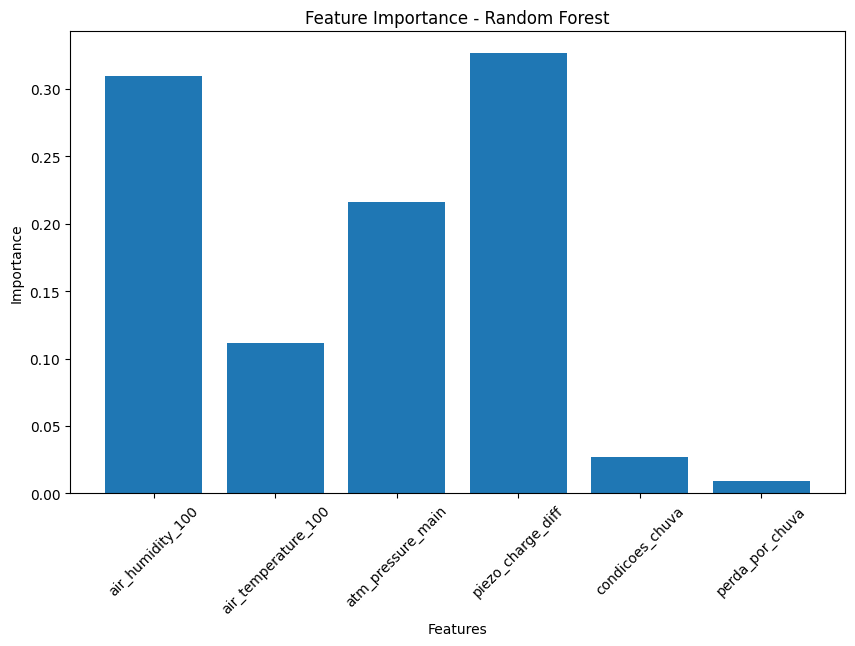

In [137]:
# Obter a importância das features
feature_importance = best_model.feature_importances_

# Criar um gráfico de barras para visualizar a importância das features
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

Vamos fazer a medição dos valores que a Estação ainda não disponibilizou com base no modelo desenvolvido.

In [138]:

dfTeste.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
1529,2020-12-04T00:00:00Z,97.0,18.98,9428,3,34889,19,NaN
1530,2020-12-04T01:00:00Z,97.0,18.62,9441,3,34833,17,NaN
1531,2020-12-04T02:00:00Z,97.0,18.46,9441,3,34778,17,NaN
1532,2020-12-04T03:00:00Z,96.0,18.82,9428,3,34723,17,NaN
1533,2020-12-04T04:00:00Z,94.0,19.36,9417,3,34665,18,NaN


In [139]:
dfTeste.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
count,182.000000,182.000000,182.000000,182.0,182.000000,182.000000,0.0
mean,73.923077,23.518462,9436.758242,3.0,27808.961538,23.582418,NaN
std,18.781224,4.708808,15.718406,0.0,4267.225778,6.879493,NaN
min,29.000000,17.720000,9390.000000,3.0,20344.000000,16.000000,NaN
25%,60.250000,19.805000,9427.000000,3.0,24198.000000,18.000000,NaN
50%,78.500000,22.040000,9439.000000,3.0,27889.500000,21.000000,NaN
75%,89.000000,26.135000,9448.000000,3.0,31160.500000,27.000000,NaN
max,97.000000,35.780000,9468.000000,3.0,34889.000000,42.000000,NaN


Vamos refazer todo o pré-processamento feito com a base treinada

In [140]:
# Preencher os valores nulos das colunas 'air_humidity_100' e 'air_temperature_100' com os valores da linha anterior
dfTeste['air_humidity_100'].fillna(method='ffill', inplace=True)
dfTeste['air_temperature_100'].fillna(method='ffill', inplace=True)

# Calculando a diferença entre os valores consecutivos de piezo_charge
dfTeste['piezo_charge_diff'] = (dfTeste['piezo_charge'].diff().fillna(method='bfill')) * (-1)

# Transformando os valores de ganho de carga pelo Reset em valor igual ao anterior
dfTeste['piezo_charge_diff'] = dfTeste['piezo_charge_diff'].where(dfTeste['piezo_charge_diff'] >= 0, dfTeste['piezo_charge_diff'].shift())

# Criar a coluna "choveu" com base nos valores da coluna "chuva" para indicar se choveu ou não
dfTeste['choveu'] = (dfTeste['chuva'] > 0).astype(int)

# Criar uma nova coluna "condicoes_chuva" que será 1 se a umidade for maior que 55 e a temperatura for menor que 25 e 0 caso contrário
dfTeste['condicoes_chuva'] = ((dfTeste['air_humidity_100'] > 55) & (dfTeste['air_temperature_100'] < 25)).astype(int)
dfTeste['condicoes_chuva'].value_counts()

# Criar uma nova coluna "condicoes_chuva" que será 1 se a umidade for maior que 60 e a temperatura for menor que 25 e 0 caso contrário
dfTeste['perda_por_chuva'] = ((dfTeste['piezo_charge_diff'] > 160)).astype(int)
dfTeste['perda_por_chuva'].value_counts()

# Dividindo os dados em características (X) e rótulo (y)
X = dfTeste.drop(['Datetime – utc','chuva','choveu','piezo_charge',"num_of_resets","piezo_temperature"], axis=1)

# Padronizar os dados de
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [141]:
# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_scaled)

# Adicionar as previsões ao dataframe original
dfTeste['predicted_target'] = y_pred
dfTeste.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva,piezo_charge_diff,choveu,condicoes_chuva,perda_por_chuva,predicted_target
count,182.000000,182.000000,182.000000,182.0,182.000000,182.000000,0.0,182.000000,182.0,182.000000,182.000000,182.000000
mean,73.923077,23.518462,9436.758242,3.0,27808.961538,23.582418,NaN,80.225275,0.0,0.686813,0.010989,0.493361
std,18.781224,4.708808,15.718406,0.0,4267.225778,6.879493,NaN,41.239213,0.0,0.465069,0.104539,0.621388
min,29.000000,17.720000,9390.000000,3.0,20344.000000,16.000000,NaN,50.000000,0.0,0.000000,0.000000,0.000000
25%,60.250000,19.805000,9427.000000,3.0,24198.000000,18.000000,NaN,57.250000,0.0,0.000000,0.000000,0.065430
50%,78.500000,22.040000,9439.000000,3.0,27889.500000,21.000000,NaN,67.000000,0.0,1.000000,0.000000,0.219108
75%,89.000000,26.135000,9448.000000,3.0,31160.500000,27.000000,NaN,92.750000,0.0,1.000000,0.000000,0.556313
max,97.000000,35.780000,9468.000000,3.0,34889.000000,42.000000,NaN,509.000000,0.0,1.000000,1.000000,2.529919
